# Testing out cleaning schema and their effects on topic modeling.
In order to have a clearer and more quantifiable understanding of how "well" the topic modeling is going and how it's being affected by changes to the preprocessing, I need to be able to see and measure what's going on.

1. Coherence and perplexity scores to quantify how useful the topics generated are at explaining underlying patterns
2. pyLDAvis to see how topics relate to each other

Copying next steps from LDA_topic_modeling.ipynb:
Next steps:
1. Grab another chunk of tweets using Tweepy (done already in getting-tweets.ipynb); possibly grab a third chunk from another point or three in time.
2. Figure out model perplexity/coherence so I know when I'm improving things; implement pyLDAvis so I can see how things are looking.
3. Replace the letter icons used for flag emojis (🇺 and 🇸 with us_flag, since that's what they represent)
4. Lowercase words - seems unlikely that capitalization is going to make a difference
5. Leave ' @\w' in place; delete ' @ ' ( == ' at ' == stop word)? Seems possible that some highly relevant Twitter handles may mean different things as hastag/plaintext vs handle.
6. How does LDA train with this cleaning scheme perform pre-removal of stop words?
7. Pull out stop words, including days of the week and day referents (today, tomorrow, yesterday)
8. How does LDA perform after stop words are removed?
9. Compare lemmatized with non-lemmatized results - is avoiding lemmatization actually making any difference?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import regex as re
import pyLDAvis.gensim

import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

spacy.load('en_core_web_md')
from spacy.lang.en import English
splp = English()
all_stopwords = splp.Defaults.stop_words

/Users/chesh1/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
covid_tweets = pd.read_csv('covid_tweets.csv', header = None)
covid_tweets.columns = ['tweet', 'user', 'id', 'symbols', 'url', 'when']

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Not exhaustive, just flags I think have enough english speakers on Twitter to be likely to show up
eng_flag_dict = {'🇦🇺': 'aus_flag', '🇨🇦': 'can_flag', '🇭🇰': 'hk_flag', '🇮🇪': 'ire_flag', '🇮🇳': 'ind_flag', 
                '🇳🇿': 'nz_flag', '🇵🇭': 'phi_flag', '🇵🇷': 'pr_flag', '🇸🇬': 'sg_flag', '🇹🇿': 'tz_flag', 
                '🇺🇸': 'us_flag', '🇺🇲': 'us_flag', '🇬🇺': 'gu_flag', '🇬🇧': 'uk_flag', '🇨🇳': 'cn_flag'}
# May be worth trying to chase down a flag translation dict somebody else has already put together?

# Converting everything to lowercase
covid_tweets['cleaned'] = covid_tweets['tweet'].str.lower()
# Strip out urls from http through to next whitespace
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'http\S+', '', regex = True)
# Change flags to their '_flag' representation as above
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(eng_flag_dict, regex = True)
# Replace all punctuation except @, _, - and apostrophes with spaces
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[.!#$%^&*()+=;:",<>?|]+', ' ', regex = True)
# Strip out apostrophes
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace("[’'`]+", '', regex = True)
# Strip out non-username at symbols
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'@(?=\s)', '', regex = True)
# Strip out digits not attached to alpha characters
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'(?<=\s)\d+(?=\s)', '', regex = True)
# Replace multiple spaces with single spaces
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'\s+', ' ', regex = True)
covid_tweets

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,user,id,symbols,url,when,cleaned
0,"Iowa averaged a pandemic high 2,266 new Covid ...",randomanne,1323862079766437888,[],NaN,2020-11-04 05:38:10,iowa averaged a pandemic high new covid infect...
1,@TheAngel_Plays @SweetPxtatoe @kiararoyale @Me...,Alex_isnotsorry,1323862068458639361,[],NaN,2020-11-04 05:38:07,@theangel_plays @sweetpxtatoe @kiararoyale @me...
2,@baxterberrie 4x this many americans died from...,magpievw,1323862066579402752,[],NaN,2020-11-04 05:38:07,@baxterberrie 4x this many americans died from...
3,@tonim57601 @MarlenaStell Covid-19...I’d hate ...,twinkie531,1323862062372737025,[],NaN,2020-11-04 05:38:06,@tonim57601 @marlenastell covid-19 id hate to ...
4,Is it covid effect? Or something else is going...,0ptimiste,1323862058845278208,[],https://t.co/KHyVcO0I6R,2020-11-04 05:38:05,is it covid effect or something else is going on
...,...,...,...,...,...,...,...
195428,Just got off a Teams call with my supervisor. ...,infoodel,1325874080772464640,[],NaN,2020-11-09 18:53:09,just got off a teams call with my supervisor i...
195429,"I do miss guard, Covid really took the last ye...",bloominggdaisyy,1325874079874904064,[],NaN,2020-11-09 18:53:08,i do miss guard covid really took the last yea...
195430,"@GilletteStadium @Patriots ""No fans in 2020"" h...",mikedacosta2,1325874079220555776,[],NaN,2020-11-09 18:53:08,@gillettestadium @patriots no fans in has noth...
195431,COVID-19\n\nRead: https://t.co/2v4KZ4zKhi,Clowzen,1325874079132487681,[],https://t.co/2v4KZ4zKhi,2020-11-09 18:53:08,covid-19 read


In [4]:
for flag in eng_flag_dict.keys():
    print(flag, covid_tweets['cleaned'].str.contains(eng_flag_dict[flag]).sum())

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


🇦🇺 38
🇨🇦 75
🇭🇰 0
🇮🇪 16
🇮🇳 16
🇳🇿 5
🇵🇭 3
🇵🇷 2
🇸🇬 3
🇹🇿 1
🇺🇸 443
🇺🇲 443
🇬🇺 0
🇬🇧 53
🇨🇳 20


In [5]:
twitter_stopwords = all_stopwords.union({'twitter', 'tweet', 'today', 'tomorrow', 'yesterday', 'monday', 'tuesday', 'wednesday', 
                                         'thursday', 'friday', 'saturday', 'sunday'})
twitter_stop_dict = dict.fromkeys(twitter_stopwords, '')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def nonstop_tokens(document):
    nlp_doc = splp(document)
    token_list = []
    for token in nlp_doc:
        lexeme = splp.vocab[token.text]
        if lexeme.text in twitter_stop_dict.keys():
            pass
        else:
            token_list.append(token)
    return token_list

def lem_words(token_list):
    return [token.lemma_ for token in token_list]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
covid_tweets['no_at'] = covid_tweets['cleaned'].str.replace('@', '', regex = True)
covid_tweets['no_stop'] = covid_tweets['cleaned'].apply(nonstop_tokens)


/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# This may be slower than replacing @ in covid_tweets['no_stop'] but I can get it to work
covid_tweets['neither'] = covid_tweets['no_at'].apply(nonstop_tokens)
covid_tweets

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,user,id,symbols,url,when,cleaned,no_at,no_stop,neither,lemmed
0,"Iowa averaged a pandemic high 2,266 new Covid ...",randomanne,1323862079766437888,[],NaN,2020-11-04 05:38:10,iowa averaged a pandemic high new covid infect...,iowa averaged a pandemic high new covid infect...,"[iowa, averaged, pandemic, high, new, covid, i...","[iowa, averaged, pandemic, high, new, covid, i...","[iowa, average, pandemic, high, new, covid, in..."
1,@TheAngel_Plays @SweetPxtatoe @kiararoyale @Me...,Alex_isnotsorry,1323862068458639361,[],NaN,2020-11-04 05:38:07,@theangel_plays @sweetpxtatoe @kiararoyale @me...,theangel_plays sweetpxtatoe kiararoyale meganp...,"[@theangel_plays, @sweetpxtatoe, @kiararoyale,...","[theangel_plays, sweetpxtatoe, kiararoyale, me...","[theangel_plays, sweetpxtatoe, kiararoyale, me..."
2,@baxterberrie 4x this many americans died from...,magpievw,1323862066579402752,[],NaN,2020-11-04 05:38:07,@baxterberrie 4x this many americans died from...,baxterberrie 4x this many americans died from ...,"[@baxterberrie, 4x, americans, died, covid, pe...","[baxterberrie, 4x, americans, died, covid, peo...","[baxterberrie, 4x, americans, die, covid, peop..."
3,@tonim57601 @MarlenaStell Covid-19...I’d hate ...,twinkie531,1323862062372737025,[],NaN,2020-11-04 05:38:06,@tonim57601 @marlenastell covid-19 id hate to ...,tonim57601 marlenastell covid-19 id hate to th...,"[@tonim57601, @marlenastell, covid-19, d, hate...","[tonim57601, marlenastell, covid-19, d, hate, ...","[tonim57601, marlenastell, covid-19, have, hat..."
4,Is it covid effect? Or something else is going...,0ptimiste,1323862058845278208,[],https://t.co/KHyVcO0I6R,2020-11-04 05:38:05,is it covid effect or something else is going on,is it covid effect or something else is going on,"[covid, effect, going]","[covid, effect, going]","[covid, effect, go]"
...,...,...,...,...,...,...,...,...,...,...,...
195428,Just got off a Teams call with my supervisor. ...,infoodel,1325874080772464640,[],NaN,2020-11-09 18:53:09,just got off a teams call with my supervisor i...,just got off a teams call with my supervisor i...,"[got, teams, supervisor, expressed, concern, c...","[got, teams, supervisor, expressed, concern, c...","[get, team, supervisor, express, concern, corp..."
195429,"I do miss guard, Covid really took the last ye...",bloominggdaisyy,1325874079874904064,[],NaN,2020-11-09 18:53:08,i do miss guard covid really took the last yea...,i do miss guard covid really took the last yea...,"[miss, guard, covid, took, year, away]","[miss, guard, covid, took, year, away]","[miss, guard, covid, take, year, away]"
195430,"@GilletteStadium @Patriots ""No fans in 2020"" h...",mikedacosta2,1325874079220555776,[],NaN,2020-11-09 18:53:08,@gillettestadium @patriots no fans in has noth...,gillettestadium patriots no fans in has nothin...,"[@gillettestadium, @patriots, fans, covid, btw]","[gillettestadium, patriots, fans, covid, btw]","[gillettestadium, patriot, fan, covid, btw]"
195431,COVID-19\n\nRead: https://t.co/2v4KZ4zKhi,Clowzen,1325874079132487681,[],https://t.co/2v4KZ4zKhi,2020-11-09 18:53:08,covid-19 read,covid-19 read,"[covid-19, read]","[covid-19, read]","[covid-19, read]"


In [22]:
covid_tweets['lemmed'] = covid_tweets['neither'].apply(lem_words)
covid_tweets

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,user,id,symbols,url,when,cleaned,no_at,no_stop,neither,lemmed
0,"Iowa averaged a pandemic high 2,266 new Covid ...",randomanne,1323862079766437888,[],NaN,2020-11-04 05:38:10,iowa averaged a pandemic high new covid infect...,iowa averaged a pandemic high new covid infect...,"[iowa, averaged, pandemic, high, new, covid, i...","[iowa, averaged, pandemic, high, new, covid, i...","[iowa, average, pandemic, high, new, covid, in..."
1,@TheAngel_Plays @SweetPxtatoe @kiararoyale @Me...,Alex_isnotsorry,1323862068458639361,[],NaN,2020-11-04 05:38:07,@theangel_plays @sweetpxtatoe @kiararoyale @me...,theangel_plays sweetpxtatoe kiararoyale meganp...,"[@theangel_plays, @sweetpxtatoe, @kiararoyale,...","[theangel_plays, sweetpxtatoe, kiararoyale, me...","[theangel_plays, sweetpxtatoe, kiararoyale, me..."
2,@baxterberrie 4x this many americans died from...,magpievw,1323862066579402752,[],NaN,2020-11-04 05:38:07,@baxterberrie 4x this many americans died from...,baxterberrie 4x this many americans died from ...,"[@baxterberrie, 4x, americans, died, covid, pe...","[baxterberrie, 4x, americans, died, covid, peo...","[baxterberrie, 4x, americans, die, covid, peop..."
3,@tonim57601 @MarlenaStell Covid-19...I’d hate ...,twinkie531,1323862062372737025,[],NaN,2020-11-04 05:38:06,@tonim57601 @marlenastell covid-19 id hate to ...,tonim57601 marlenastell covid-19 id hate to th...,"[@tonim57601, @marlenastell, covid-19, d, hate...","[tonim57601, marlenastell, covid-19, d, hate, ...","[tonim57601, marlenastell, covid-19, have, hat..."
4,Is it covid effect? Or something else is going...,0ptimiste,1323862058845278208,[],https://t.co/KHyVcO0I6R,2020-11-04 05:38:05,is it covid effect or something else is going on,is it covid effect or something else is going on,"[covid, effect, going]","[covid, effect, going]","[covid, effect, go]"
...,...,...,...,...,...,...,...,...,...,...,...
195428,Just got off a Teams call with my supervisor. ...,infoodel,1325874080772464640,[],NaN,2020-11-09 18:53:09,just got off a teams call with my supervisor i...,just got off a teams call with my supervisor i...,"[got, teams, supervisor, expressed, concern, c...","[got, teams, supervisor, expressed, concern, c...","[get, team, supervisor, express, concern, corp..."
195429,"I do miss guard, Covid really took the last ye...",bloominggdaisyy,1325874079874904064,[],NaN,2020-11-09 18:53:08,i do miss guard covid really took the last yea...,i do miss guard covid really took the last yea...,"[miss, guard, covid, took, year, away]","[miss, guard, covid, took, year, away]","[miss, guard, covid, take, year, away]"
195430,"@GilletteStadium @Patriots ""No fans in 2020"" h...",mikedacosta2,1325874079220555776,[],NaN,2020-11-09 18:53:08,@gillettestadium @patriots no fans in has noth...,gillettestadium patriots no fans in has nothin...,"[@gillettestadium, @patriots, fans, covid, btw]","[gillettestadium, patriots, fans, covid, btw]","[gillettestadium, patriot, fan, covid, btw]"
195431,COVID-19\n\nRead: https://t.co/2v4KZ4zKhi,Clowzen,1325874079132487681,[],https://t.co/2v4KZ4zKhi,2020-11-09 18:53:08,covid-19 read,covid-19 read,"[covid-19, read]","[covid-19, read]","[covid-19, read]"


In [24]:
def token2text(token_list):
    return [token.text for token in token_list]

covid_tweets['no_stop'] = covid_tweets['no_stop'].apply(token2text)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Setting up LDA using no_stop lists; neither and lemma later.
id2word = Dictionary(covid_tweets['no_stop'])
# Thresholds of 0.1% and 70% chosen somewhat arbitrarily; may tune later
id2word.filter_extremes(no_below = 0.001, no_above = 0.7)
corpus = [id2word.doc2bow(d) for d in covid_tweets['no_stop']]
LDA_model = LdaMulticore(corpus = corpus, num_topics = 6, id2word = id2word, passes = 5)
# Pulling out just words
words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA_model.print_topics()]

In [27]:
topics = [' '.join(t[0:20]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
covid trump nt biden people @realdonaldtrump president s covid-19 -

------ Topic 1 ------
covid-19 vaccine cases - new pfizer health deaths covid19 effective

------ Topic 2 ------
covid-19 covid - vaccine 🤣 new – game government  

------ Topic 3 ------
covid nt m people like s got know mask going

------ Topic 4 ------
covid “ ” amp force task thank covid-19 help hope

------ Topic 5 ------
covid - positive covid-19 tested test tests testing school /



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Computing perplexity; note that lower score is better
LDA_perplexity = LDA_model.log_perplexity(corpus)
print('\nPerplexity: ', LDA_perplexity) 

# Topic coherence
coherence_model = CoherenceModel(model = LDA_model, texts = covid_tweets['lemmed'], dictionary = id2word, coherence = 'c_v')
coherence_LDA_model = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_LDA_model)

Issues/iterating:
1. May need to do something about apostrophes so they're all the same character
2. Add isolated punctuation to stopword dictionary
3. Add standard covid words (covid, covid-19) to stopword dictionary as they're showing up in multiple topics

In [34]:
covid_tweets = pd.read_csv('covid_tweets.csv', header = None)
covid_tweets.columns = ['tweet', 'user', 'id', 'symbols', 'url', 'when']

# Not exhaustive, just flags I think have enough english speakers on Twitter to be likely to show up
eng_flag_dict = {'🇦🇺': 'aus_flag', '🇨🇦': 'can_flag', '🇭🇰': 'hk_flag', '🇮🇪': 'ire_flag', '🇮🇳': 'ind_flag', 
                '🇳🇿': 'nz_flag', '🇵🇭': 'phi_flag', '🇵🇷': 'pr_flag', '🇸🇬': 'sg_flag', '🇹🇿': 'tz_flag', 
                '🇺🇸': 'us_flag', '🇺🇲': 'us_flag', '🇬🇺': 'gu_flag', '🇬🇧': 'uk_flag', '🇨🇳': 'cn_flag'}
# May be worth trying to chase down a flag translation dict somebody else has already put together?

# Converting everything to lowercase
covid_tweets['cleaned'] = covid_tweets['tweet'].str.lower()
# Strip out urls from http through to next whitespace
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'http\S+', '', regex = True)
# Change flags to their '_flag' representation as above
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(eng_flag_dict, regex = True)
# Replace all punctuation except _, - and apostrophes with spaces
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[.!/#$%^&*()+=;:"“”,<>?|]+', ' ', regex = True)
# Get apostrophes consistent
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace("[’'`]+", "'", regex = True)
# Strip out dashes and underscores not within word characters
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[-_]+(?=\s)', '', regex = True)
# Strip out digits not attached to alpha characters
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'(?<=\s)\d+(?=\s)', '', regex = True)
# Replace multiple spaces with single spaces
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'\s+', ' ', regex = True)
covid_tweets

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet,user,id,symbols,url,when,cleaned
0,"Iowa averaged a pandemic high 2,266 new Covid ...",randomanne,1323862079766437888,[],NaN,2020-11-04 05:38:10,iowa averaged a pandemic high new covid infect...
1,@TheAngel_Plays @SweetPxtatoe @kiararoyale @Me...,Alex_isnotsorry,1323862068458639361,[],NaN,2020-11-04 05:38:07,@theangel_plays @sweetpxtatoe @kiararoyale @me...
2,@baxterberrie 4x this many americans died from...,magpievw,1323862066579402752,[],NaN,2020-11-04 05:38:07,@baxterberrie 4x this many americans died from...
3,@tonim57601 @MarlenaStell Covid-19...I’d hate ...,twinkie531,1323862062372737025,[],NaN,2020-11-04 05:38:06,@tonim57601 @marlenastell covid-19 i'd hate to...
4,Is it covid effect? Or something else is going...,0ptimiste,1323862058845278208,[],https://t.co/KHyVcO0I6R,2020-11-04 05:38:05,is it covid effect or something else is going on
...,...,...,...,...,...,...,...
195428,Just got off a Teams call with my supervisor. ...,infoodel,1325874080772464640,[],NaN,2020-11-09 18:53:09,just got off a teams call with my supervisor i...
195429,"I do miss guard, Covid really took the last ye...",bloominggdaisyy,1325874079874904064,[],NaN,2020-11-09 18:53:08,i do miss guard covid really took the last yea...
195430,"@GilletteStadium @Patriots ""No fans in 2020"" h...",mikedacosta2,1325874079220555776,[],NaN,2020-11-09 18:53:08,@gillettestadium @patriots no fans in has noth...
195431,COVID-19\n\nRead: https://t.co/2v4KZ4zKhi,Clowzen,1325874079132487681,[],https://t.co/2v4KZ4zKhi,2020-11-09 18:53:08,covid-19 read


In [35]:
twitter_stopwords = all_stopwords.union({'twitter', 'tweet', 'today', 'tomorrow', 'yesterday', 'monday', 'tuesday', 'wednesday', 
                                         'thursday', 'friday', 'saturday', 'sunday', 'amp', '-', '_', '"', 'covid-19', 'covid'})
twitter_stop_dict = dict.fromkeys(twitter_stopwords, '')

covid_tweets['no_at'] = covid_tweets['cleaned'].str.replace('@', '', regex = True)
covid_tweets['no_stop'] = covid_tweets['cleaned'].apply(nonstop_tokens)
covid_tweets['neither'] = covid_tweets['no_at'].apply(nonstop_tokens)
covid_tweets['lemmed'] = covid_tweets['neither'].apply(lem_words)
covid_tweets['no_stop'] = covid_tweets['no_stop'].apply(token2text)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Setting up LDA using no_stop lists; neither and lemma later.
id2word = Dictionary(covid_tweets['no_stop'])
# Thresholds of 0.1% and 70% chosen somewhat arbitrarily; may tune later
id2word.filter_extremes(no_below = 0.001, no_above = 0.7)
corpus = [id2word.doc2bow(d) for d in covid_tweets['no_stop']]
LDA_model = LdaMulticore(corpus = corpus, num_topics = 6, id2word = id2word, passes = 5)
# Pulling out just words
words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA_model.print_topics()]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Computing perplexity; note that lower score is better
LDA_perplexity = LDA_model.log_perplexity(corpus)
print('\nPerplexity: ', LDA_perplexity) 

In [47]:
# Topic coherence
coherence_model = CoherenceModel(model = LDA_model, corpus = corpus, dictionary = id2word, coherence = 'u_mass')
coherence_LDA_model = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_LDA_model)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  -3.784096533904261


In [33]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(LDA_model, corpus, id2word)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.189272  0.025732       1        1  22.068160
3      0.120448  0.017424       2        1  18.766608
2      0.206782  0.048998       3        1  18.656093
4     -0.189232 -0.098840       4        1  14.237955
5     -0.091311 -0.236627       5        1  13.621604
1     -0.235959  0.243312       6        1  12.649579, topic_info=             Term          Freq         Total Category  logprob  loglift
231       vaccine  20384.000000  20384.000000  Default  30.0000  30.0000
17          cases  13736.000000  13736.000000  Default  29.0000  29.0000
157         trump  20051.000000  20051.000000  Default  28.0000  28.0000
1483     positive   9346.000000   9346.000000  Default  27.0000  27.0000
36          biden  12395.000000  12395.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
12           week   1658.906122   4352.563751   Topic6  -5.2334   1.1029
1521      testing   1592.507731   3989.219674   Topic6  -5.2743   1.1493
265   coronavirus   1618.398145   4405.520654   Topic6  -5.2582   1.0661
72         health   1277.351566   6353.440366   Topic6  -5.4948   0.4633
28         people   1277.551525  21135.150499   Topic6  -5.4947  -0.7384

[439 rows x 6 columns], token_table=       Topic      Freq Term
term                       
358        1  0.030637     
358        2  0.061454     
358        3  0.011173     
358        4  0.474149     
358        5  0.256628     
...      ...       ...  ...
1295       3  0.999727    🤣
2633       6  0.998667    🤦
15402      3  0.997612    🤬
738        6  0.999095    🤷
2311       2  0.998812    🥺

[995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 6, 2])

More missed punctuation tokens, curses and damnation. 
“
”
Re-ran the whole reading in the .csv, cleaning, tokenizing loop yet again.

# Comparing the cleaning schema
Essentially, which column gets "better" topics (and, I hope, better coherence)? Because this work is taking half of forever, I'm going to export the tweets dataframe to csv, then pull out a sample of 10k tweets to test various approaches on.

## Sample dataframe for comparison purposes

In [55]:
covid_tweets.to_csv('cleaned_covid_tweets.csv')

covid_sample = covid_tweets[['tweet', 'user', 'cleaned', 'no_at', 'no_stop', 'neither', 'lemmed']].sample(10000)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
covid_sample.to_csv('sample_covid_tweets.csv')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
covid_sample = pd.read_csv('sample_covid_tweets.csv')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# More aggressive cleaning scheme after first NMF round
# Not exhaustive, just flags I think have enough english speakers on Twitter to be likely to show up
eng_flag_dict = {'🇦🇺': 'aus_flag', '🇨🇦': 'can_flag', '🇭🇰': 'hk_flag', '🇮🇪': 'ire_flag', '🇮🇳': 'ind_flag', 
                '🇳🇿': 'nz_flag', '🇵🇭': 'phi_flag', '🇵🇷': 'pr_flag', '🇸🇬': 'sg_flag', '🇹🇿': 'tz_flag', 
                '🇺🇸': 'us_flag', '🇺🇲': 'us_flag', '🇬🇺': 'gu_flag', '🇬🇧': 'uk_flag', '🇨🇳': 'cn_flag'}
# May be worth trying to chase down a flag translation dict somebody else has already put together?

# Converting everything to lowercase
covid_sample['cleaned2'] = covid_sample['tweet'].str.lower()
# Strip out urls from http through to next whitespace
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'http\S+', '', regex = True)
# Get apostrophes consistent
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace("[’'`]+", "'", regex = True)
# Strip out all characters outside standard set, per https://stackoverflow.com/questions/20078816/replace-non-ascii-characters-with-a-single-space/20079244#20079244
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'[^\x00-\x7f]', '', regex = True)
# Replace - and _ with empty string
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'[-_]+', '', regex = True)
# Replace all punctuation except apostrophes with spaces
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'[.!/#$%^&*()+=\;:"“”,<>?@/|]+', ' ', regex = True)
# Strip out digits
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'[0-9]+', '', regex = True)
# Change flags to their '_flag' representation as above
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(eng_flag_dict, regex = True)
# Replace multiple spaces with single spaces
covid_sample['cleaned2'] = covid_sample['cleaned2'].replace(r'\s+', ' ', regex = True)
covid_sample

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,tweet,user,cleaned,no_at,no_stop,neither,lemmed,cleaned2
0,32663,oh my god I wish I hadn’t ate all of my gf’s X...,gracelandproj,oh my god i wish i hadn't ate all of my gf's x...,oh my god i wish i hadn't ate all of my gf's x...,"['oh', 'god', 'wish', 'ate', 'gf', 'xanax', 's...","['oh', 'god', 'wish', 'ate', 'gf', 'xanax', 's...","['oh', 'god', 'wish', 'eat', 'gf', 'xanax', 's...",oh my god i wish i hadn't ate all of my gf's x...
1,45062,COVID-19 has felt like the group project from ...,cubegrl,covid-19 has felt like the group project from ...,covid-19 has felt like the group project from ...,"['felt', 'like', 'group', 'project', 'hell', '...","['felt', 'like', 'group', 'project', 'hell', '...","['feel', 'like', 'group', 'project', 'hell', '...",covid has felt like the group project from hel...
2,186921,"""COVID-19 experts were expecting the first vac...",CloserToTruth,covid-19 experts were expecting the first vac...,covid-19 experts were expecting the first vac...,"[' ', 'experts', 'expecting', 'vaccines', 'eff...","[' ', 'experts', 'expecting', 'vaccines', 'eff...","[' ', 'expert', 'expect', 'vaccine', 'effectiv...",covid experts were expecting the first vaccin...
3,69861,https://t.co/m6cHRsaFi9\n\nessa playlist me cu...,victor_vassalo,essa playlist me curou do covid,essa playlist me curou do covid,"[' ', 'essa', 'playlist', 'curou']","[' ', 'essa', 'playlist', 'curou']","[' ', 'essa', 'playlist', 'curou']",essa playlist me curou do covid
4,187023,Covid-19 vaccine from Pfizer and BioNTech is s...,ndejde,covid-19 vaccine from pfizer and biontech is s...,covid-19 vaccine from pfizer and biontech is s...,"['vaccine', 'pfizer', 'biontech', 'strongly', ...","['vaccine', 'pfizer', 'biontech', 'strongly', ...","['vaccine', 'pfizer', 'biontech', 'strongly', ...",covid vaccine from pfizer and biontech is stro...
...,...,...,...,...,...,...,...,...,...
9996,49287,"Nov. 3 COVID-19 Update: 5 Fatalities, 5 New Ca...",ksstradio1230,nov covid-19 update fatalities new cases,nov covid-19 update fatalities new cases,"['nov', 'update', 'fatalities', 'new', 'cases']","['nov', 'update', 'fatalities', 'new', 'cases']","['nov', 'update', 'fatality', 'new', 'case']",nov covid update fatalities newcases
9997,170446,Trump literally cured COVID-19 https://t.co/Z0...,Paul48355351,trump literally cured covid-19,trump literally cured covid-19,"['trump', 'literally', 'cured']","['trump', 'literally', 'cured']","['trump', 'literally', 'cure']",trump literally cured covid
9998,60027,@Vogel_Liebe @AngelAdrian2017 Covid 19 scamste...,AdrianoMazzola,@vogel_liebe @angeladrian2017 covid scamsters ...,vogel_liebe angeladrian2017 covid scamsters so...,"['@vogel_liebe', '@angeladrian2017', 'scamster...","['vogel_liebe', 'angeladrian2017', 'scamsters'...","['vogel_liebe', 'angeladrian2017', 'scamsters'...",vogelliebe angeladrian covid scamsters soon t...
9999,20616,@rnscott12 If covid hadn't happened Trump wins...,Simmons360,@rnscott12 if covid hadn't happened trump wins...,rnscott12 if covid hadn't happened trump wins ...,"['@rnscott12', 'happened', 'trump', 'wins', 'l...","['rnscott12', 'happened', 'trump', 'wins', 'la...","['rnscott12', 'happen', 'trump', 'win', 'lands...",rnscott if covid hadn't happened trump wins i...


In [78]:
twitter_stopwords = all_stopwords.union({'twitter', 'tweet', 'today', 'tomorrow', 'yesterday', 'monday', 'tuesday', 'wednesday', 
                                         'thursday', 'friday', 'saturday', 'sunday', 'amp', 'covid', 'vaccine', 'carson', 'trump', 
                                         'biden', 'deaths', 'election', 'elections', 'vote', 'votes', 'voting', 'cases', 'pfizer', 
                                        'biontech', 'realdonaldtrump', 'effective', 'like'})
twitter_stop_dict = dict.fromkeys(twitter_stopwords, '')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## NMF

In [79]:
# TFIDF setup
corpus = covid_sample['cleaned2'].fillna(value='')
tfidf = TfidfVectorizer(stop_words = twitter_stopwords)
tweet_word_matrix = tfidf.fit_transform(corpus)
vocab = tfidf.get_feature_names()
# NMF
nmf = NMF(n_components=10)
nmf.fit(tweet_word_matrix)
# Topic matrix
tweet_topic_matrix = nmf.transform(tweet_word_matrix)
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')
tweet_topic_matrix_df[['raw_tweets', 'clean_tweets']] = covid_sample[['tweet', 'cleaned2']]
tweet_topic_matrix_df.head()

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,raw_tweets,clean_tweets
0,0.006433,0.001255,0.000000,0.001159,0.000670,0.004534,0.003976,0.000000,0.000000,0.000000,oh my god I wish I hadn’t ate all of my gf’s X...,oh my god i wish i hadn't ate all of my gf's x...
1,0.006219,0.000448,0.000000,0.001368,0.000562,0.000919,0.012925,0.041421,0.011358,0.000249,COVID-19 has felt like the group project from ...,covid has felt like the group project from hel...
2,0.009931,0.001417,0.001526,0.000000,0.015249,0.000000,0.000000,0.001954,0.000000,0.000000,"""COVID-19 experts were expecting the first vac...",covid experts were expecting the first vaccin...
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,https://t.co/m6cHRsaFi9\n\nessa playlist me cu...,essa playlist me curou do covid
4,0.012796,0.000000,0.002103,0.000000,0.002870,0.000000,0.000000,0.000000,0.001325,0.000000,Covid-19 vaccine from Pfizer and BioNTech is s...,covid vaccine from pfizer and biontech is stro...


In [80]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
aafa,0.001554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aafotograph,0.000000,0.000000,0.000000,0.000000,0.000000,0.000794,0.000435,0.000097,0.000195,0.000000
aakash,0.000079,0.000000,0.001616,0.000000,0.000000,0.000000,0.000000,0.000079,0.000000,0.000000
aamalll,0.000000,0.007597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aan,0.000973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
zurlo,0.000588,0.000000,0.000000,0.000000,0.002758,0.000000,0.000000,0.000000,0.000000,0.000000
zweli,0.000000,0.000000,0.006413,0.003963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
zwitterion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004686,0.003155,0.000000,0.000000
zz,0.000909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000978,0.005047


In [81]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

Well isn't this good news 
https://t.co/4oZOtG5djc

Then he said trump didn’t say anything about covid because everyone made the pandemic bigger then it should’ve been... https://t.co/OTaUjAVG6Q

@SteveScalise I'm reporting this tweet b/c it is clearly misrepresenting what Gov. Cuomo said on this 26 sec. clip. He never said the drug was bad news, he said Trump's lack of a Covid-19 plan is bad news. Huge difference.

COVID-19 is likely to change the way businesses operate for a long time. Here's how some elements surrounding the pandemic will build the next generation of entrepreneurs.

    https://t.co/w6IP3CTRGO

COVID-19 is likely to change the way businesses operate for a long time. Here's how some elements surrounding the pandemic will build the next generation of entrepreneurs.

    https://t.co/vVTNYHsEQC

COVID-19 is likely to change the way businesses operate for a long time. Here's how some elements surrounding the pandemic will build the next generation of entrepreneurs.

   

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

"HUD Secretary Ben Carson has tested positive for COVID-19"  https://t.co/1u2U7qUIMe

"HUD Secretary Ben Carson has tested positive for COVID-19"  https://t.co/sfVtcSuF1n

HUD Secretary Ben Carson has tested positive for COVID-19  https://t.co/dyrwQdoPOZ

HUD Secretary Ben Carson has tested positive for COVID-19 https://t.co/OO1OTiU3jx

HUD Secretary Ben Carson has tested positive for COVID-19  https://t.co/I0kjZgcbSx

HUD Secretary Ben Carson has tested positive for COVID-19  https://t.co/3CRrpHKK8U

"HUD Secretary Ben Carson has tested positive for COVID-19"  https://t.co/7hqWuzWfWx

HUD Secretary Ben Carson has tested positive for COVID-19  https://t.co/3s7c4rmLVa

HUD Secretary Ben Carson has tested positive for COVID-19  https://t.co/CqOBsBN5wE

"HUD Secretary Ben Carson has tested positive for COVID-19"  https://t.co/PfNwK4sBgm



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

so ... 226 new covid cases announced today in SLO county ... is a lot of new cases. We have 474 active cases total, 47.7% of which are new cases .....

Orange County on Tuesday reported 306 new cases of COVID-19 and 1 new death https://t.co/hEfizafHns

Another COVID death, 50 new cases
https://t.co/ZxT4mWji6s

We are counting 828 new confirmed COVID-19 cases in Idaho today — the same number as yesterday (weird, but we also had 666, 777 and 888 in a 10-day span).

The state reported 353 new probable cases — so that's a record 1,181 total new cases today.

There were 909 new cases and 13 new deaths reported in Montana this morning: https://t.co/C1vckpdx7t

COVID-19 USA stats

New cases: +63665
Total cases: 9631208
New deaths: +854
Total deaths: 237848

#UPDATE 196 new cases of COVID-19 in McLennan County, 11,289 total, two new deaths https://t.co/RcE32KdJ8R #fox44tx https://t.co/YTomDyluL8

U.S. COVID update: Number in hospital reaches 50,000, more than 1,000 new deaths

- New cases: 86,

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_3', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

People with covid.

people who think trump did “everything he could do” about covid 🤡

All the people who died from covid can't vote think about that

over 200,000 people have died from covid and it’s still this close

@DearAuntCrabby With all the covid in Florida and all the people who have died there...what are these people thinking?

He’s killed 230,000+ people with Covid and y’all still voting for him?

over one thousand people died today of covid

Do you think his people even believe in Covid? https://t.co/ntfmCXffK0

@Lady_Star_Gem Almost 1,000 people dying a day from COVID and some people are like give me more of the same. Unbelievable this country

People really don't give a fuck about COVID, do they?



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_4', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

My first COVID test! https://t.co/2igkzfKxle

Get your COVID Test y'all https://t.co/qn4yvrcfpi

Covid test negative!!🤩 https://t.co/hsGr7MT59G

The covid test is not as bad as yall made it seem

The symptoms are worse than the test

This COVID test every Monday is killing me 🥴

Covid-19 testing: Here's why you can be contagious but still test negative https://t.co/fSBBfbDwNU

Passed my covid test

The Covid test doesn’t get better 😅

I’m at the covid test. I’m at the voting place. I’m at the combination covid test and voting place. https://t.co/MhC2XGgJ73

Here's why you can test negative for Covid-19 but still be infected and contagious

https://t.co/thcMp7gF1K



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_5', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

I don’t ever want to hear that COVID isn’t real again... 😢

People who don’t believe Covid-19 is real and don’t want the vaccine, that’s up to you. For the rest of us, an effective vaccine is a very welcome breakthrough and gives us hope 😊

People really don't give a fuck about COVID, do they?

Don't  Just  Told    Us  Their  Is  A  Vaccine  For  Covid  Tell  Us  The  Name  Of  The  Vaccine  Please  Is  It  Safe  No  One  Know

@SandraLeeCleary @RonDeSantisFL @realDonaldTrump so you don't care that he's a traitor? You don't care that he's ignored Covid and made it WORSE in the US? You don't care that that has tanked the economy and killed tens of thousands needlessly?  You don't care that he encourages hatred and violence?

Please America. I don’t want this pandemic to last forever. I want a president who will actually do something to make COVID go away.

@MufcRadek Ik college ain’t bad that’s not my point. My point is that half my class have Covid and I don’t want to catch it cause I 

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_6', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

got tested for covid yesterday

But hey, at least we got the Covid vaccine. https://t.co/8MLUkJOcx0

my mom just got an email from school saying a student got covid....

How does a vaccine work that is 90% effective? Does that mean that 10.000 people in every 100.000 still got Covid?

@CrankGameplays Voted for the first time, got exposed to covid, got tested for it, waited for election results, got my whole family to play among us, made like 15 loaves of bread, skipped school, church, and work for 4 days, chopped off half my hair and got bangs...
Yeah I'd agree

Guess who’s work just got stopped again because of Covid 👍🏻

Just got the news my grandpa got covid 🤦🏽‍♂️
Issa wrap

My mom got hit with covid and today was the first time in a month I got to give her a hug💕 brought so much joy to my heart

guess who got exposed to covid and has to quarantine 🤩 https://t.co/wUOHa0e0F5

Even the good doctor got covid. What a shit show.



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_7', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

@realDonaldTrump Hey, are you going to tweet about all the people in your admin who are getting covid?

I can’t believe I’m going to be 30 this year. And of course covid restrictions are getting worse. I’m sad.

Trump getting Covid https://t.co/1yky0YZm4Y

ONLY reason this is going to be "close" is because of COVID. Without COVID, Trump walks this election. Still looking like hes going to win.

Best part of Trump winning: Wray getting fired or Covid going away tomorrow?

Also how is anyone still testing positive for covid? I was told this was going to go away after the election.

now why New Jersey covid cases going up... https://t.co/xEUlA8sMyn

@legalminimum @Kareshy_Zen @BadLegalTakes Thank you! Well, things are still going what with COVID and all, but at least it's going to be normal now.

"This pandemic is not getting better at this point; it's getting worse." https://t.co/eHx9Nf0jaj

"This pandemic is not getting better at this point; it's getting worse." https://t.co/6mhqZwLk71


/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_8', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

So y’all are mad Melania who had COVID &amp; no longer has it but has antibodies didn’t wear a mask in a county without a mask mandate in a state without a mask mandate? 🙄 https://t.co/B1ZablsU7n

Everywhere I go I wear a mask, including at work. All people I come in contact with wear a mask. Except  @MetrobusTransit where nobody social distances &amp; wearing masks are not enforced. So if I get Covid-19, probably pretty easy to know where I contracted it. #COVID19NL

PRESIDENT BIDEN: "We can save thousands of lives if we just wear a mask." https://t.co/P1P7ueh57J

i could be sat shoulder to shoulder next to somebody in class with no mask but in the corridor it’s exactly the same but i have to wear a mask. if they had covid they have already given it to me and wearing a mask will not make me not have covid.

The way i kept thinking why janhvi didn’t wear the N95 mask is driving me crazy i’m like : what if she gets covid ? is that mask effective ? it doesn’t seems like it 🤨

@AndyBeshea

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_9', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

people who think trump did “everything he could do” about covid 🤡

Do you think his people even believe in Covid? https://t.co/ntfmCXffK0

All the people who died from covid can't vote think about that

Damn. My uncle has covid. If you think it can’t happen to you or someone you love, think again.

@redbaronfan123 when i think of the year 2020 when i’m 46, i’ll think of 2 things... covid &amp; ikea trip 😎

I still can’t believe this is just our life now. like when you really think about it covid is never gonna fully go away and we’re just going to have to deal with that shit for the rest of our lives I think.... how exciting.

@leftwinggal And I sincerely think it was only this close because of Covid and social unrest.. if not I think trump would’ve won by even more

I think the covid vaccine should feminize you

@dansinker Think he has COVID?

@Mikel_Jollett Less to do with Biden more to do with COVID vaccine...don't you think.



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## NMF results:
### First pass:
Vocab includes a lot of crap like 00, 000, 000s, and 00am at the head, and some nonstandard characters (odd fonts, Korean characters) at the tail. Can I figure out a more aggressive cleaning scheme using unicode character ranges?

Topics:
0. Negative about COVID; includes people who are exasperated that even with COVID the election was as close as it is and people expressing skepticism that COVID is all that bad because they haven't seen a population crash.
1. Stats/number-heavy; obviously focusing on numbers rather than reality.
2. Vaccine chatter (Pfizer, BioNTech)
3. News links? All the top stuff is "HUD Secretary Ben Carson has tested positive for COVID-19"
4. Biden, Trump, voting.

### First pass conclusions:
Need to clean more aggressively, not enough topics.

### Second pass:
Topics:
0. Unclear jumble - includes time off work, mask skepticism, people lamenting length of quarantine
1. Case numbers and stats
2. New vaccine
3. Carson again
4. Trump getting COVID, voting
5. Exasperation that some people don't care about COVID as well as that one "well it isn't a problem because the population hasn't crashed" tweet.
6. Election
7. Vote vote vote (sentiment all over the place)
8. Biden
9. Deaths

### Second pass results:
NMF seems to be segmenting on certain keywords rather than an underlying topic. Adding vaccine, Carson, Trump, Biden, deaths, election, vote, votes, voting, cases, pfizer, biontech to stop words - does this help or just cause it to segment on something else?

### Third pass:
Topics:
0. Pandemic, worse, economy, vaccine, somebody telling Pfizer they did take gov't money
1. Ben Carson
2. Case numbers
3. COVID skepticism and people dunking on COVID skepticism?
4. COVID testing
5. Jumble - commonality may be something on the "like" "looks like" "as if" axis? (Way of talking rather than topic)
6. Get serious about it, keep your masks on motherfuckers, etc.
7. Mostly bad news: got covid, have to quarantine, have to get tested, etc.
8. Trumpety trump trump trump
9. Pfizer/effective (all tweets have both)

### Third pass results:
Adding realdonaldtrump, like, & effective to stop words; results are feeling better but may be hitting the limits of what I can get with NMF.

### Fourth pass:
0. Segmenting largely on 'news' token, I think; still has that tweet "calling out" Pfizer for taking gov't $
1. Still Ben Carson
2. Cases
3. Skeptics and dunking on skeptics
4. Testing
5. Earnest anti-skeptics
6. Mostly people talking about friends/family getting or getting exposed to COVID or quarantining
7. Election-covid intersection, generally factual or dunking on Trump administration
8. Mask up, jerks
9. Anger - highest tweets are angry at COVID skeptics but a couple are angry about anti-COVID measures?

### Fourth pass results
Feels like I'm really getting much closer, though I'm hitting the limits of what I can do with the very patchy data I'm dealing with. Going to set up so that I'm pulling COVID tweets in smaller batches at regularly spaced intervals throughout the last month, then start again here.

## See getting-tweets.ipynb for new tweet pull

In [90]:
covid_tweets = pd.read_csv('covid_tweets2.csv', header = None)
covid_tweets.columns = ['tweet', 'user', 'id', 'symbols', 'url', 'when']
# Repeating cleaning exactly as prior to fourth NMF run except for moving flag replacement to before weird character strip
covid_tweets['cleaned'] = covid_tweets['tweet'].str.lower()
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'http\S+', '', regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace("[’'`]+", "'", regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(eng_flag_dict, regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[^\x00-\x7f]', '', regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[-_]+', '', regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[.!/#$%^&*()+=\;:"“”,<>?@/|]+', ' ', regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'[0-9]+', '', regex = True)
covid_tweets['cleaned'] = covid_tweets['cleaned'].replace(r'\s+', ' ', regex = True)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
twitter_stopwords = all_stopwords.union({'twitter', 'tweet', 'today', 'tomorrow', 'yesterday', 'monday', 'tuesday', 'wednesday', 
                                         'thursday', 'friday', 'saturday', 'sunday', 'amp', 'covid', 'vaccine', 'carson', 'trump', 
                                         'biden', 'deaths', 'election', 'elections', 'vote', 'votes', 'voting', 'cases', 'pfizer', 
                                        'biontech', 'realdonaldtrump', 'effective', 'like', 'tweets'})
# TFIDF setup
corpus = covid_tweets['cleaned'].fillna(value='')
tfidf = TfidfVectorizer(stop_words = twitter_stopwords)
tweet_word_matrix = tfidf.fit_transform(corpus)
vocab = tfidf.get_feature_names()
# NMF
nmf = NMF(n_components=10)
nmf.fit(tweet_word_matrix)
# Topic matrix
tweet_topic_matrix = nmf.transform(tweet_word_matrix)
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')
tweet_topic_matrix_df[['raw_tweets', 'clean_tweets']] = covid_tweets[['tweet', 'cleaned']]
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
for tweet in tweet_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


How long are they actually going to let covid control our lives? It’s already been 7 months surely once it gets to a year they’re just going to have to let us live with it and for it to run it’s course. We can’t be going in and out of lockdowns forever 🙄

Who's going first? https://t.co/nb5qKgSqR8

Covid, covid, covid, covid. Still not going away! https://t.co/d1MI2BOejV

@pcrickard @GovMLG The problem is, this virus isn’t going anywhere. Even if we get a vaccine in the early part of the year, it’s going to be a long time before we’ve kicked this to the curb. We are going to be dealing with Covid well into the middle or late next year...

@JoeBiden You will never be my president. But if you really believe you are then why are COVID #’s going up. Get your ass to work!

@ToddRowleyPA13 @MsPacNWer We don’t know that we’re going to be ok.  This isn’t over. He’s not going away. Racism is not going away. His supporters are not going away.  Covid is not going away. Economy isn’t bouncing back

In [92]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

Yesterday, the U.S. had 107,872 new COVID cases and 1,616 deaths. https://t.co/UXeXlggRcy

Meanwhile 100,000 new covid cases...

Two more deaths from Covid-19 &amp; 542 new cases https://t.co/wRQhAjH0Hq

New York New Covid-19 Cases Top 3,000, Most Since Early May

140,000 new cases of COVID reported today in the US 🙆🏿‍♂️ https://t.co/00WrsOgleq

100k new covid cases today in the US for the first time https://t.co/qBVxpjJIh4

NEW: 281 new COVID-19 cases in Monroe County, no deaths reported

Idaho officials reported 1,266 new COVID-19 cases and 12 new deaths on Monday. https://t.co/BDNuSPq9u9

NEW - 1388 new Ontario COVID-19 cases today. 15 deaths and 29,125 tests completed.

Ontario reports 1,242 new COVID-19 cases today, 12 new deaths and 2,460 new cases over the weekend. 

The Niagara Region reports 18 cases today, one new death and 55 new cases this weekend. 

https://t.co/CCqBTCGXqR

#niagara #ontario #COVID19 #niagararegion #coronavirus



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

just tested positive for covid 🙃

I tested positive for Covid 🙃🙃

I tested positive to covid 🥴

Tested positive for COVID-19

I’ve just tested Positive for Covid.

White House Chief of Staff, Mark Meadows, tests positive for Covid-19
https://t.co/Lmf62MCgdv

White House chief of staff Mark Meadows tests positive for COVID-19 https://t.co/mUUiXwKYNG

White House chief of staff Mark Meadows tests positive for coronavirus https://t.co/kHdg4bey8e

White House chief of staff Mark Meadows tests positive for #COVID19 #coronavirus https://t.co/UVfz0j3pTi

White house chief of staff tests positive for covid-19



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_3', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

COVID-19 is not over people. https://t.co/7opURCo0Ji

@ketchums2012 @realDonaldTrump So that more people can die from COVID19. There were 140k people confirmed covid yesterday and 1000 people died.

Covid didn’t take enough people out...

1,859 people today died of Covid-19. An additional 134,383 people contracted covid.

@realDonaldTrump @BreitbartNews Only if more people would have died from Covid.

all the people i know getting covid while i somehow have not https://t.co/wRlABdS1ez

Yeah because people voted for Biden.. it’s the same way that people are testing positive for Covid because they are getting tested! https://t.co/bFcSeFc7Zo

The fact that over 200,000 people have died from Covid and going and people still think Trump is fit to lead the country is beyond me.

I heard Trump say everything was going well. Tell that to the people that are still getting it, the people that have lost their mother/ Father has died from it. The hospital's are so crowded with Covid  people a quie

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_4', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

@realDonaldTrump @BreitbartNews Trump’s Legacy.

If you don’t test people for Covid.
Then you don’t have Covid.
If you don’t count the votes.
Then you don’t get voted out of office.

I really don’t want to take another COVID test 🥴

Had a patient say "I don't know anyone who has had COVID." And I was like, "Hi, my name is Becky. Now you know someone who has had COVID." And they said, "But you don't count. You work here." So, there you have it, fellow healthcare workers. We don't count. Until they need us.

I really hope I don’t have covid 😅

i don’t want covid thank you

Don't forget this...
https://t.co/b5yIdFP7oi

Just cause you don’t get tested for covid or don’t have symptoms doesn’t mean you don’t have it and people wonder why this virus keeps spreading 😒

COVID Life hack — if you don’t go out you don’t get sick

I'm not a Biden supporter but I respect his plan. I just have three things I don't want Biden to do. 1) Don't force Americans to take the Vaccine. 2) Don't force us to ge

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_5', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

i have to get a covid test today

Covid. Get a test. https://t.co/OM4H3Ggbxo

test covid 🤫🥴

Covid test negative!! 🙏🏼

Going in for a covid test today 😖

My Covid test came back negative 🙏

My #COVID test came back and it's negative

Got my results back for Covid 19 test...I’m negative

I’m taking my first covid 19 test today 🥺

gonna go get a covid test😬



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_6', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

got covid

trump got the whole 2020 experience , this man got covid AND lost his job

I think I got COVID 🥺

@realDonaldTrump Trump is living the full 2020 experience:
He got covid-19
Lost his job
And got evicted

someone at my work got covid 🙃

Trump got the full united states in 2020 experience: got covid, lost his job and is about to be evicted

Trump got the full 2020 experience!!! He got Covid, just got fired and soooooon he’ll be evicted!!!!!

got tested for covid today https://t.co/jLYBes3Qmj

just got covid tested

@cnnbrk @realDonaldTrump got the full 2020 experience. He got covid, lost his job and is being evicted from his home.



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_7', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

90% of news about covid and trump https://t.co/UeQPo7QxCR

Good news, not Covid
Bad news, pneumonia https://t.co/4SBPvrv02f

Great news on COVID-19 front. https://t.co/CggKAwCMwk

And in other really bad news. 

https://t.co/peXscIWVeW

Good news: I actually slept pretty well last night. Bad news: I had a dream that I tested positive for COVID. Good news: it was (probably) only a dream. Bad news: I can't now get back to sleep. Good news: this tweet is making a decent feedback sandwich

Remember when covid was on the news

Good news in the daily COVID-19 numbers. https://t.co/Y2Em5PX1iA

If there is any good news, it is that after Jan 2021 Biden will own all the deaths from COVID https://t.co/2eqQPJOVKU

@BreitbartNews 90% of news about covid and trump

I am glad Covid is no news ! US election is !



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_8', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

Day 5 is pretty much over.

Still no COVID symptoms.

Onto Day 6.

As we are having over 120,000 cases a day and over 1,000 deaths a day. They continue and add to the COVID-19 pandemic. https://t.co/31T5AqlseA

I have not heard one word on Covid since election day. I am seeing people out in droves w/masks. If you can get out of your house  w/a mask on,  election day should be election day. Stop with the early voting and mass mail in. Thats why its called election day!! #Election2020

For first time, US #COVID_19 cases top 1️⃣0️⃣0️⃣,0️⃣0️⃣0️⃣ in single day. https://t.co/nCJpWieVJD

Today is the day that millions might lose their health insurance.

Today is also the day we could set a record number of new Covid cases.

Today is the day trump should concede.  #TrumpConcede

@theharryshearer And to have it also be on Victory Over Covid Day is too much - it's like like if Arbor Day was on Flag Day  - CRAZY!

595 people gone, in one day,  from Covid

@RealKiddWaya The day Covid vaccine will 

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
for tweet in tweet_topic_matrix_df.sort_values(by='topic_9', ascending=False).head(10)['raw_tweets'].values:
    print(tweet)
    print()

Wear Mask. Do Not Follow Those Not Wearing Mask.

Wear Mask. Say No To Herd Immunity

Wear Mask. Fight Covid-19.

Wear Mask. Stop The Infection.

Wear Mask. Stop The Deaths

Wear Mask. Keep Hands Clean

Wear Mask. Practice Social Distancing.

Wear Mask 

Keep America &amp; World Safe

Did nothing to stop Covid, got Covid, lost the election, and still not wearing a mask. https://t.co/Vdsubv2Cyo

I have zero faith in a covid-19 vaccine.
 Wear your mask. Don't be selfish. Wear your mask. Wash your hands. Wear your mask. Order in from local shops. Wear your mask. Parent your children. Wear your mask. Learn a new skill. Wear your mask.

https://t.co/5OZem7WuTX

Covid's still out there. Mask up!

Covid made me stop https://t.co/WV8a8jHRus

@realDonaldTrump STOP THE COVID!!!!!!!

STOP COVID! https://t.co/Iu89d4l4IH

STOP THE COVID!

@realDonaldTrump STOP COVID!!!!!!!!

Here we go again! Please wear a mask and be safe, everyone! https://t.co/RZaCvCvQfB



/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## New data NMF first pass:
Topics:
0. Unclear beyond ill sentiment - angry about lockdowns, worried about big societal issues, angry about Trump superspreader events, conspiracy theories about engineered viruses.
1. Case and test numbers
2. Tested positive
3. High case and death rates
4. Unclear - don't want to have covid, don't know about things, COVID is Trump's legacy, don't want Biden to mandate masks or lockdown
5. Getting tested for COVID and negative test results
6. "got covid" with a lot of tweets about how Trump got COVID
7. "news"
8. "day"
9. Mask wearing (no particular valence/sentiment) and "stop COVID"

# Shifting gears to LDA
Upside of NMF is its speed per run, even with 100k Tweets. Downside is definitely that the manual analysis is slow as hell. It does seem to be helpful for iteratively running through which stopwords definitely need to get added to the specialized set, but it feels like I'm really going to struggle to settle on a number of topics, and more, it seems like the number of coherent topics is going to be higher than 10 (which will be hell on wheels to manually chug through), given that a lot of topics seem to end up being a mix of sentiments on a particular topic and I'm going to want to segment down to specific views.

In [101]:
from sklearn.decomposition import LatentDirichletAllocation
# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
twitter_stopwords = all_stopwords.union({'twitter', 'tweet', 'today', 'tomorrow', 'yesterday', 'monday', 'tuesday', 'wednesday', 
                                         'thursday', 'friday', 'saturday', 'sunday', 'amp', 'covid', 'vaccine', 'carson', 'trump', 
                                         'biden', 'deaths', 'election', 'elections', 'vote', 'votes', 'voting', 'cases', 'pfizer', 
                                        'biontech', 'realdonaldtrump', 'effective', 'like', 'tweets', 'got', 
                                        'day', 'news'})

def tweet_cleaning_func(df, start, destination):
    df[destination] = df[start].str.lower()
    df[destination] = df[destination].replace(r'http\S+', '', regex = True)
    df[destination] = df[destination].replace("[’'`]+", "'", regex = True)
    df[destination] = df[destination].replace(eng_flag_dict, regex = True)
    df[destination] = df[destination].replace(r'[^\x00-\x7f]', '', regex = True)
    df[destination] = df[destination].replace(r'[-_]+', '', regex = True)
    df[destination] = df[destination].replace(r'[.!/#$%^&*()+=\;:"“”,<>?@/|]+', ' ', regex = True)
    df[destination] = df[destination].replace(r'[0-9]+', '', regex = True)
    df[destination] = df[destination].replace(r'\s+', ' ', regex = True)
    return None

covid_tweets = pd.read_csv('covid_tweets2.csv', header = None)
covid_tweets.columns = ['tweet', 'user', 'id', 'symbols', 'url', 'when']
tweet_cleaning_func(covid_tweets, 'tweet', 'cleaned')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Enjoy your cleaned tweets!'

In [104]:
tf_vectorizer = CountVectorizer(stop_words = twitter_stopwords,
                                lowercase = False,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 0.001)
dtm_tf = tf_vectorizer.fit_transform(covid_tweets['cleaned'])
print(dtm_tf.shape)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(28000, 1967)


In [106]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(covid_tweets['cleaned'])
print(dtm_tfidf.shape)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


(28000, 1967)


In [107]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=20, random_state=0)

In [109]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

vis1 = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.save_html(vis1, 'vs1_lda.html')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Rebuilding so I can get coherence
While I've got code I can just copy-paste for the LDA using sklearn, I can't really compute coherence without doing all kinds of detours if I'm not going through gensim directly. Since lifting code wholesale from Amin Azad's post resulted in NaNs for coherence because I obviously don't understand what's going on under the hood and so can't troubleshoot it effectively, we're going back to the beginning and working through the gensim LDA workflow. Destination I'm hoping for is looping through LDAs with various topic numbers and graphing coherence to try and find the elbow.

In [110]:
docs = covid_tweets['cleaned'].tolist()

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
twitter_stop_dict = dict.fromkeys(twitter_stopwords, '')
def rem_stopwords(doc_list):
    """
    Takes cleaned tweets and returns them as lists of words
    """
    return [[word for word in doc.split() if word not in twitter_stop_dict.keys()] for doc in doc_list]

def lemm_it(doc_list_list, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Takes documents as lists of words from rem_stopwords and lemmatizes them using spacy
    """
    lemmed_texts = []
    for doc in doc_list_list:
        text = nlp(' '.join(doc))
        lemmed_texts.append([token.lemma_ for token in text if token.pos_ in allowed_postags])
    return lemmed_texts

# Removing stopwords, including custom stopwords defined above
tweets_no_stops = rem_stopwords(docs)
# Initializing spacy english model with only tagger component since that's all I'm using here
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
tweets_lemmed = lemm_it(tweets_no_stops)
tweets_lemmed[:2]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['desperate',
  'break',
  'headline',
  'view',
  'desk',
  'assure',
  'take',
  'care',
  'single',
  'extended',
  'household',
  'tier',
  'come',
  'stay',
  'total',
  'peace',
  'mind',
  'covidsafeholiday'],
 ['real', 'wrong', 'people', 'upset', 'end', 'depressed', 'positive']]

In [116]:
# Creating the components required for LDA
id2word = Dictionary(tweets_lemmed)
texts = tweets_lemmed
corpus = [id2word.doc2bow(text) for text in texts]
corpus[:2]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 15:30:24,602 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-12 15:30:25,235 : INFO : adding document #10000 to Dictionary(10435 unique tokens: ['assure', 'break', 'care', 'come', 'covidsafeholiday']...)
2020-11-12 15:30:25,645 : INFO : adding document #20000 to Dictionary(15119 unique tokens: ['assure', 'break', 'care', 'come', 'covidsafeholiday']...)
2020-11-12 15:30:26,049 : INFO : built Dictionary(18321 unique tokens: ['assure', 'break', 'care', 'come', 'covidsafeholiday']...) from 28000 documents (total 247561 corpus positions)


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1)],
 [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]

In [118]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('assure', 1),
  ('break', 1),
  ('care', 1),
  ('come', 1),
  ('covidsafeholiday', 1),
  ('desk', 1),
  ('desperate', 1),
  ('extended', 1),
  ('headline', 1),
  ('household', 1),
  ('mind', 1),
  ('peace', 1),
  ('single', 1),
  ('stay', 1),
  ('take', 1),
  ('tier', 1),
  ('total', 1),
  ('view', 1)]]

In [119]:
from gensim.models.ldamodel import LdaModel
lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=20)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 15:35:28,533 : INFO : using symmetric alpha at 0.05
2020-11-12 15:35:28,552 : INFO : using symmetric eta at 0.05
2020-11-12 15:35:28,566 : INFO : using serial LDA version on this node
2020-11-12 15:35:28,652 : INFO : running online (single-pass) LDA training, 20 topics, 1 passes over the supplied corpus of 28000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-11-12 15:35:28,678 : INFO : PROGRESS: pass 0, at document #2000/28000
2020-11-12 15:35:30,116 : INFO : merging changes from 2000 documents into a mode

In [120]:
coherence_model_lda = CoherenceModel(model = lda_model, texts = tweets_lemmed, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 15:37:12,393 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-11-12 15:37:16,741 : INFO : serializing accumulator to return to master...
2020-11-12 15:37:16,749 : INFO : serializing accumulator to return to master...
2020-11-12 15:37:16,749 : INFO : serializing accumulator to return to master...
2020-11-12 15:37:16,915 : INFO : accumulator serialized
2020-11-12 15:37:17,100 : INFO : accumulator serialized
2020-11-12 15:37:16,918 : INFO : accumulator serialized
2020-11-12 15:37:17,622 : INFO : 3 accumulators retrieved from output queue
2


Coherence Score:  0.3105925427689685


In [121]:
topic_number = [6, 9, 12, 15, 18, 22, 23, 26, 29, 32, 35, 40, 45, 50]
# Initializing with coherence score already calculated for 20 topics
coherence_scores = {20: 0.3105925427689685}
for num in topic_number:
    lda_model = LdaModel(corpus = corpus,
                        id2word = id2word, 
                        num_topics = num)
    coherence_model_lda = CoherenceModel(model = lda_model, texts = tweets_lemmed, dictionary = id2word, coherence = 'c_v')
    coherence_scores[num] = coherence_model_lda.get_coherence()

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 16:02:15,973 : INFO : using symmetric alpha at 0.16666666666666666
2020-11-12 16:02:15,979 : INFO : using symmetric eta at 0.16666666666666666
2020-11-12 16:02:15,991 : INFO : using serial LDA version on this node
2020-11-12 16:02:16,014 : INFO : running online (single-pass) LDA training, 6 topics, 1 passes over the supplied corpus of 28000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-11-12 16:02:16,018 : INFO : PROGRESS: pass 0, at document #2000/28000
2020-11-12 16:02:17,803 : INFO : merging changes fr

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 0.38749419726711676)

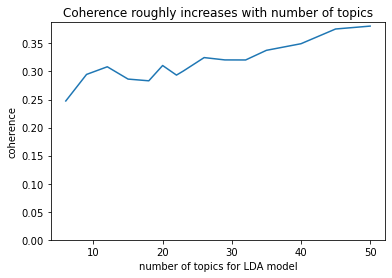

In [126]:
coherence_tuples = [(num, coherence_scores[num]) for num in coherence_scores.keys()]
topics = [x[0] for x in coherence_tuples]
coherence = [x[1] for x in coherence_tuples]
sbn.lineplot(x = topics, y = coherence)
plt.title('Coherence roughly increases with number of topics')
plt.xlabel('number of topics for LDA model')
plt.ylabel('coherence')
plt.ylim(bottom = 0)

## What do topics look like for 12 topics and 45 topics?
12 appears to be approximately the first inflection point of the number of topics graphed, and 45 appears to be when it flattens out again. I want to look at the keywords and see which one "feel" like a better fit for the data.

In [127]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=12)
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 16:24:04,150 : INFO : using symmetric alpha at 0.08333333333333333
2020-11-12 16:24:04,161 : INFO : using symmetric eta at 0.08333333333333333
2020-11-12 16:24:04,171 : INFO : using serial LDA version on this node
2020-11-12 16:24:04,208 : INFO : running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 28000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-11-12 16:24:04,222 : INFO : PROGRESS: pass 0, at document #2000/28000
2020-11-12 16:24:05,520 : INFO : merging changes f

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.154309 -0.026039       1        1  14.057618
2      0.027270 -0.018598       2        1   9.196298
9     -0.094662  0.003627       3        1   9.002284
8     -0.037125  0.013763       4        1   8.811771
5     -0.073436 -0.041645       5        1   8.668801
7      0.054983 -0.104565       6        1   8.465111
3     -0.001431  0.219139       7        1   8.224471
6     -0.031377  0.141090       8        1   8.223244
11     0.309419  0.057495       9        1   6.784237
10     0.058444 -0.193842      10        1   6.198349
0     -0.069099  0.013868      11        1   6.194231
1      0.011322 -0.064292      12        1   6.173584, topic_info=          Term         Freq        Total Category  logprob  loglift
264       test  1901.000000  1901.000000  Default  30.0000  30.0000
404       mask  1556.000000  1556.000000  Default  29.0000  29.0000
21    positive   957.000000   957.000000  Default  28.0000  28.0000
408       wear   848.000000   848.000000  Default  27.0000  27.0000
865       rate   561.000000   561.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
568        say   106.633924  1488.459243  Topic12  -4.9651   0.1488
79        time   103.596788  1375.425746  Topic12  -4.9940   0.1989
386     happen    81.140416   496.799824  Topic12  -5.2383   0.9729
3         come    78.957904  1071.154160  Topic12  -5.2656   0.1773
1791      dead    71.217192   193.473471  Topic12  -5.3688   1.7855

[861 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
25        1  0.036880   able
25        2  0.008195   able
25        3  0.127029   able
25        4  0.040977   able
25        5  0.065564   able
...     ...       ...    ...
950       1  0.007004  young
950       4  0.987566  young
950       5  0.007004  young
2816      8  0.977181  youth
2487      1  0.986190   zone

[2729 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 10, 9, 6, 8, 4, 7, 12, 11, 1, 2])

In [128]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=45)
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 16:26:19,873 : INFO : using symmetric alpha at 0.022222222222222223
2020-11-12 16:26:19,894 : INFO : using symmetric eta at 0.022222222222222223
2020-11-12 16:26:19,902 : INFO : using serial LDA version on this node
2020-11-12 16:26:20,096 : INFO : running online (single-pass) LDA training, 45 topics, 1 passes over the supplied corpus of 28000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-11-12 16:26:20,116 : INFO : PROGRESS: pass 0, at document #2000/28000
2020-11-12 16:26:21,362 : INFO : merging changes

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27    -0.173656  0.036778       1        1  3.815977
6      0.109258 -0.036892       2        1  3.205949
26    -0.028513  0.034194       3        1  2.941317
33     0.128272  0.070503       4        1  2.764620
41    -0.024524  0.097462       5        1  2.730547
34    -0.088247 -0.042678       6        1  2.725632
43    -0.131923 -0.053695       7        1  2.676509
8     -0.070829 -0.057910       8        1  2.646324
0     -0.106613  0.110696       9        1  2.568597
2      0.048922 -0.129030      10        1  2.566406
16    -0.080479  0.062110      11        1  2.565989
9     -0.120638 -0.039407      12        1  2.542833
1      0.008907  0.042343      13        1  2.520700
20    -0.042107  0.095849      14        1  2.493142
4      0.038141 -0.009194      15        1  2.451741
31     0.140394 -0.077786      16        1  2.341264
35    -0.108864  0.093505      17        1  2.307588
29    -0.010429 -0.170716      18        1  2.280502
7     -0.144429 -0.057764      19        1  2.279448
42    -0.072239  0.079195      20        1  2.227698
24    -0.009524  0.023390      21        1  2.201572
25     0.006495  0.051354      22        1  2.187043
12    -0.058000 -0.152502      23        1  2.179823
21    -0.033990  0.062741      24        1  2.152019
39    -0.026937 -0.101061      25        1  2.149230
11     0.032829 -0.047040      26        1  2.142455
10     0.046841  0.037228      27        1  2.087378
22     0.029349  0.040357      28        1  2.073163
36    -0.058422  0.019443      29        1  2.064927
40     0.173642  0.078261      30        1  2.050819
14    -0.022304 -0.073954      31        1  1.940508
19     0.110919 -0.139319      32        1  1.885475
37    -0.002978  0.019411      33        1  1.849704
28     0.119950 -0.003019      34        1  1.845167
5     -0.050734 -0.011703      35        1  1.843311
18     0.063302  0.050775      36        1  1.753937
44     0.012359 -0.006105      37        1  1.753803
32     0.068149  0.073111      38        1  1.752857
38     0.096513  0.064403      39        1  1.723551
3      0.001340 -0.072579      40        1  1.717238
17    -0.008437 -0.053544      41        1  1.680632
15     0.166586 -0.010039      42        1  1.668334
13     0.043405  0.120428      43        1  1.603530
30    -0.001432 -0.043416      44        1  1.550113
23     0.030674  0.025815      45        1  1.490628, topic_info=         Term         Freq        Total Category  logprob  loglift
264      test  1852.000000  1852.000000  Default  30.0000  30.0000
98        new  1434.000000  1434.000000  Default  29.0000  29.0000
404      mask  1402.000000  1402.000000  Default  28.0000  28.0000
100       die  1361.000000  1361.000000  Default  27.0000  27.0000
21   positive   930.000000   930.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
646     woman   125.664513   155.016057  Topic45  -3.3798   3.9961
114   private    67.871049    96.262252  Topic45  -3.9958   3.8565
69      right    58.988329   664.375136  Topic45  -4.1361   1.7845
129      work    64.691451  1412.441970  Topic45  -4.0438   1.1225
139    safety    34.268665   233.765700  Topic45  -4.6792   2.2859

[2109 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1909      6  0.957073       'd
1909     22  0.026221       'd
1909     40  0.008740       'd
3286     30  0.947441  abandon
1198      4  0.948265  ability
...     ...       ...      ...
950      19  0.013092    young
950      28  0.117830    young
2816     26  0.969515    youth
2487     41  0.987757     zone
1119     44  0.956695     zoom

[5770 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 7, 27, 34, 42, 35, 44, 9, 1, 3, 17, 10, 2, 21, 5, 32, 36, 30, 8, 43, 25, 26, 13, 22, 40, 12, 11, 23, 37, 41, 15,

In [131]:
lda_model[corpus][0]

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3, 0.10096971), (10, 0.040455274), (20, 0.06356428), (31, 0.74439025)]

In [162]:
# Creating dataframe which gives the proportion of each topic for each tweet
topic_tweet_list = []
for i in range(len(lda_model[corpus])):
    tweet_dict = dict.fromkeys([x for x in range(45)])
    row = lda_model[corpus][i]
    for (topic_number, prop_topic) in row:
        tweet_dict[topic_number] = prop_topic
    topic_tweet_list.append(tweet_dict)
topic_tweet_df = pd.DataFrame(topic_tweet_list)

topic_tweet_df = topic_tweet_df.join(covid_tweets['tweet'])

topic_tweet_df = topic_tweet_df.fillna(0)

topic_tweet_df

In [163]:
# Top 5 tweets for each topic
topic_tweets = []
for i in range(45):
    topic_dict = {}
    keywords = lda_model.show_topic(i)
    topic_dict['keywords'] = [word for (word, prop) in keywords]
    temp_df = topic_tweet_df.sort_values(by = i, ascending = False)
    topic_dict[0] = temp_df.iloc[0, -1]
    topic_dict[1] = temp_df.iloc[1, -1]
    topic_dict[2] = temp_df.iloc[2, -1]
    topic_dict[3] = temp_df.iloc[3, -1]
    topic_dict[4] = temp_df.iloc[4, -1]
    topic_tweets.append(topic_dict)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
topics_df = pd.DataFrame(topic_tweets)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [166]:
topic_tweets_45 = topic_tweets

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'keywords': ['see',
   'go',
   'market',
   'year',
   'cancel',
   'long',
   'global',
   'fuck',
   'fall',
   'literally'],
  0: '@berniespofforth I know, I know. I just don’t think you needed to say the last bit.',
  1: 'How long y’all think this Covid shit guna last? Another year ?',
  2: 'Global Sugammadex Market to Make a greater Stride Amidst Covid-19 in 2020–2027 - The Think Curiouser https://t.co/K3288Ur0uR',
  3: 'I miss you babes! I’m sorry Covid got in the way of everything planned this year....2021 WILL be better 🥰',
  4: 'Independent shops have been "more agile" and better at surviving Covid-19 than chain stores, data indicates https://t.co/MPU895vfQD via @BBCNews'},
 {'keywords': ['happen',
   'hear',
   'business',
   'company',
   'story',
   'scientist',
   'include',
   'quarantine',
   'matter',
   'small'],
  0: 'In a battle where two near corpses battled it out for what feels like 27 years, I suppose this was inevitable.... https://t.co/Fme6npNohE',
  1: '@ki

In [167]:
gensim_45_topics = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(gensim_45_topics, 'lda_45_topics.html')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
topic_tweet_df_45 = topic_tweet_df

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=12)
gensim_12_topics = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(gensim_12_topics, 'lda_12_topics.html')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-11-12 21:32:34,649 : INFO : using symmetric alpha at 0.08333333333333333
2020-11-12 21:32:34,660 : INFO : using symmetric eta at 0.08333333333333333
2020-11-12 21:32:34,672 : INFO : using serial LDA version on this node
2020-11-12 21:32:34,722 : INFO : running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 28000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-11-12 21:32:34,736 : INFO : PROGRESS: pass 0, at document #2000/28000
2020-11-12 21:32:37,081 : INFO : merging changes f

In [170]:
# Creating dataframe which gives the proportion of each topic for each tweet
topic_tweet_list = []
for i in range(len(lda_model[corpus])):
    tweet_dict = dict.fromkeys([x for x in range(12)])
    row = lda_model[corpus][i]
    for (topic_number, prop_topic) in row:
        tweet_dict[topic_number] = prop_topic
    topic_tweet_list.append(tweet_dict)
topic_tweet_df_12 = pd.DataFrame(topic_tweet_list)

topic_tweet_df_12 = topic_tweet_df_12.join(covid_tweets['tweet'])

topic_tweet_df_12 = topic_tweet_df_12.fillna(0)

topic_tweet_df_12

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11,tweet
0,0.091024,0.000000,0.000000,0.862694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Desperate for a break from the headlines and t...
1,0.010422,0.010422,0.010423,0.010422,0.010423,0.154492,0.138908,0.010422,0.143832,0.479391,0.010422,0.010422,"@shortround131 @mmpadellan No your not crazy, ..."
2,0.088772,0.000000,0.000000,0.000000,0.664545,0.000000,0.000000,0.000000,0.189329,0.000000,0.000000,0.000000,@DmodosCutter @vintagecpk @Laboursupportuk I’m...
3,0.000000,0.000000,0.000000,0.445626,0.240940,0.000000,0.000000,0.000000,0.269308,0.000000,0.000000,0.000000,"Businesses providing essential groceries, medi..."
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124220,0.510464,0.281795,0.000000,0.000000,0.000000,"Join us tomorrow for a panel discussion on ""Pr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.000000,0.140270,0.155318,0.000000,0.000000,0.000000,0.657543,0.000000,0.000000,0.000000,0.000000,0.000000,@UGifter we're gonna get our covid tests sched...
27996,0.013886,0.013886,0.013886,0.013886,0.013886,0.013886,0.498982,0.013886,0.013886,0.013887,0.013886,0.362158,More people getting sick at another party for ...
27997,0.000000,0.092198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.274826,0.347564,0.080404,0.163353,"@AndreaHorwath Sure, all the hearts are aching..."
27998,0.011886,0.228044,0.011887,0.011886,0.011887,0.159201,0.357769,0.011887,0.011886,0.011887,0.011886,0.159894,"@donwinslow Oh that’s just @ChanelRion, the sa..."


In [171]:
# Top 5 tweets for each topic
topic_tweets_12 = []
for i in range(12):
    topic_dict = {}
    keywords = lda_model.show_topic(i)
    topic_dict['keywords'] = [word for (word, prop) in keywords]
    temp_df = topic_tweet_df.sort_values(by = i, ascending = False)
    topic_dict[0] = temp_df.iloc[0, -1]
    topic_dict[1] = temp_df.iloc[1, -1]
    topic_dict[2] = temp_df.iloc[2, -1]
    topic_dict[3] = temp_df.iloc[3, -1]
    topic_dict[4] = temp_df.iloc[4, -1]
    topic_tweets_12.append(topic_dict)
topic_tweets_12

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'keywords': ['new',
   'number',
   'report',
   'high',
   'record',
   'rate',
   'surge',
   'total',
   'infection',
   'lose'],
  0: '@berniespofforth I know, I know. I just don’t think you needed to say the last bit.',
  1: 'How long y’all think this Covid shit guna last? Another year ?',
  2: 'Global Sugammadex Market to Make a greater Stride Amidst Covid-19 in 2020–2027 - The Think Curiouser https://t.co/K3288Ur0uR',
  3: 'I miss you babes! I’m sorry Covid got in the way of everything planned this year....2021 WILL be better 🥰',
  4: 'Independent shops have been "more agile" and better at surviving Covid-19 than chain stores, data indicates https://t.co/MPU895vfQD via @BBCNews'},
 {'keywords': ['rise',
   'case',
   'story',
   'update',
   'new',
   'late',
   'say',
   'look',
   'hear',
   'restaurant'],
  0: 'In a battle where two near corpses battled it out for what feels like 27 years, I suppose this was inevitable.... https://t.co/Fme6npNohE',
  1: '@kirigwi But then h

In [174]:
topic_tweet_df_12.to_csv('12_topic_LDA_w_tweets.csv')
topic_tweet_df_45.to_csv('45_topic_LDA_w_tweets.csv')
with open('12_topic_LDA_top_tweets.txt', 'w') as file:
    file.write(str(topic_tweets_12))
with open('45_topic_LDA_top_tweets.txt', 'w') as file:
    file.write(str(topic_tweets_45))

/Users/chesh1/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'topic_tweets_45' is not defined